# Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
TRAIN_PATH = "/content/drive/MyDrive/DeepLearning_Models/UNET /data/stage1_train/stage1_train.zip (Unzipped Files)"
TEST_PATH = "/content/drive/MyDrive/DeepLearning_Models/UNET /data/stage1_test/stage1_test.zip (Unzipped Files)"

In [5]:
import os
import cv2
from tqdm.notebook import tqdm
import numpy as np
from skimage.io import imread
from skimage.transform import resize

# Data Gen

In [8]:
import tensorflow as tf

In [9]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [10]:
image_size = 128
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(TRAIN_PATH))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [12]:
gen = DataGen(train_ids, TRAIN_PATH, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


# Model

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, \
                                    Input, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

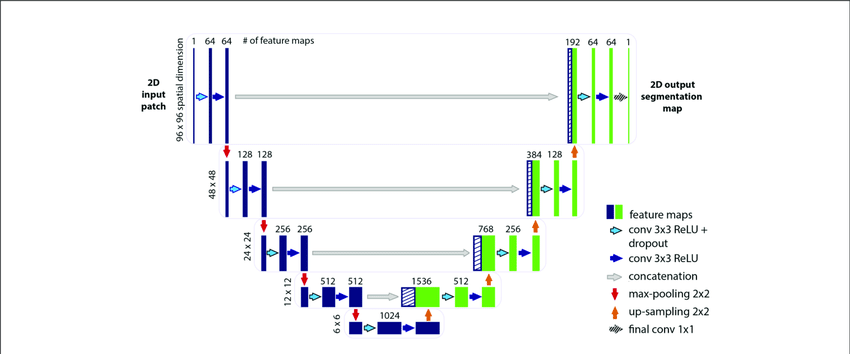

In [ ]:
input = Input((128,128,3), name='input')
x = Lambda(lambda x: x / 255)(input)

# Encoder Block  (filters custom - 16, 32, 64, 128, 256)
c1 = Conv2D(16, (3,3), padding="same", activation="relu", name="conv1_1")(x)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(16, (3,3), padding="same", activation="relu", name="conv1_2")(c1)

c2 = MaxPooling2D((2,2), padding="same", name="pool1_1")(c1)
c2 = Conv2D(32, (3,3), padding="same", activation="relu", name="conv2_1")(c2)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, (3,3), padding="same", activation="relu", name="conv2_2")(c2)

c3 = MaxPooling2D((2,2), padding="same",name="pool2_1")(c2)
c3 = Conv2D(64, (3,3), padding="same", activation="relu", name="conv3_1")(c3)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), padding="same", activation="relu",name="conv3_2")(c3)

c4 = MaxPooling2D((2,2), padding="same",name="pool3_1")(c3)
c4 = Conv2D(128, (3,3), padding="same", activation="relu",name="conv4_1")(c4)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), padding="same", activation="relu",name="conv4_2")(c4)

c5 = MaxPooling2D((2,2), padding="same",name="pool4_1")(c4)
c5 = Conv2D(256, (3,3), padding="same", activation="relu",name="conv5_1")(c5)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(256, (3,3), padding="same", activation="relu",name="conv5_2")(c5)

# Decoder block (128, 64, 32, 16)
u1 = Conv2DTranspose(128, (3,3), padding="same",strides=(2,2))(c5)
u1 = Concatenate(axis=3)([u1, c4])
u1 = Conv2D(128, (3,3), padding="same", activation="relu")(u1)
u1 = Dropout(0.2)(u1)
u1 = Conv2D(128, (3,3), padding="same",activation="relu")(u1)

u2 = Conv2DTranspose(64, (3,3), padding="same",strides=(2,2))(u1)
u2 = Concatenate(axis=3)([u2, c3])
u2 = Conv2D(64, (3,3), padding="same",activation="relu")(u2)
u2 = Dropout(0.2)(u2)
u2 = Conv2D(64, (3,3), padding="same",activation="relu")(u2)

u3 = Conv2DTranspose(32, (3,3), padding="same", strides=(2,2))(u2)
u3 = Concatenate(axis=3)([u3, c2])
u3 = Conv2D(32, (3,3), padding="same",activation="relu")(u3)
u3 = Dropout(0.2)(u3)
u3 = Conv2D(32, (3,3), padding="same",activation="relu")(u3)

u4 = Conv2DTranspose(16, (3,3), padding="same", strides=(2,2))(u3)
u4 = Concatenate(axis=3)([u4, c1])
u4 = Conv2D(16, (3,3), padding="same",activation="relu")(u4)
u4 = Dropout(0.2)(u4)
u4 = Conv2D(16, (3,3), padding="same",activation="relu")(u4)

output = Conv2D(1, (1,1), padding="same")(u4)

model = Model(inputs=[input], outputs=[output])


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv1_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
xtrain = X_train / 255.0
ytrain = y_train / 255.0
xtest = X_test / 255.0

In [17]:

#Build the model
inputs = tf.keras.layers.Input((128, 128, 3))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [18]:
train_gen = DataGen(train_ids, TRAIN_PATH, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, TRAIN_PATH, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
82/82 [==============================] - 3523s 42s/step - loss: 0.5061 - accuracy: 0.8159 - val_loss: 0.3036 - val_accuracy: 0.8386
Epoch 2/5
82/82 [==============================] - 1604s 20s/step - loss: 0.2066 - accuracy: 0.8975 - val_loss: 0.3767 - val_accuracy: 0.8204
Epoch 3/5
82/82 [==============================] - 921s 11s/step - loss: 0.1450 - accuracy: 0.9303 - val_loss: 0.2936 - val_accuracy: 0.8541
Epoch 4/5
82/82 [==============================] - 503s 6s/step - loss: 0.1097 - accuracy: 0.9429 - val_loss: 0.3137 - val_accuracy: 0.8439
Epoch 5/5
82/82 [==============================] - 198s 2s/step - loss: 0.1092 - accuracy: 0.9421 - val_loss: 0.2647 - val_accuracy: 0.8674


In [19]:
model.save_weights("/content/drive/MyDrive/DeepLearning_Models/UNET /UNetW.h5")

In [20]:
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

In [22]:
import matplotlib.pyplot as plt

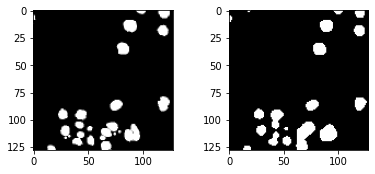

In [23]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")